<b> IMPORTING DATA </b>

In [1]:
# Read data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get numeric
chunk = pd.read_csv(r'C:\Users\draga\Documents\Time Series Forecasting - Anomaly Detection\bosch-production-line-performance\train_numeric.csv', dtype = np.float32, iterator=True, chunksize=1000)
train_numeric = pd.concat(chunk)
# Save file for later use
train_numeric.to_pickle("train_numeric.pkl")
print('numerical imported')

# Get date
train_date = pd.read_csv(r'C:\Users\draga\Documents\Time Series Forecasting - Anomaly Detection\bosch-production-line-performance\train_date.csv', nrows=10000)
# Read station times
date_cols = test_date.drop('Id', axis=1).count().reset_index().sort_values(by=0, ascending=False)
date_cols['station'] = date_cols['index'].apply(lambda s: s.split('_')[1])
date_cols = date_cols.drop_duplicates('station', keep='first')['index'].tolist()
print(date_cols) # selected features
# Save file for later use
train_date.to_pickle("train_date.pkl")

<b>INVESTIGATING COLUMNS</b>

In [17]:
# Stations per line
line_0, line_1, line_2, line_3 = [],[],[],[]
for column in train_numerical.columns:
    if column == 'Id' or column == 'Response': continue
    line = int(column.split("_")[0][1:])
    station = column.split("_")[1][1:]
    feature = column.split("_")[2][1:]
    if line == 0:
        if station not in line_0: line_0.append(station)
    elif line == 1:
        if station not in line_1: line_1.append(station)
    elif line == 2:
        if station not in line_2: line_2.append(station)
    elif line == 3:
        if station not in line_3: line_3.append(station)

In [4]:
# How many lines and stations
date_lines = []
date_stations = []
date_features = []
for column in train_date.columns:
    if column == 'Id' or column == 'Response': continue
    line = column.split("_")[0][1:]
    station = column.split("_")[1][1:]
    feature = column.split("_")[2][1:]
    if line not in date_lines:
        date_lines.append(line)
    if station not in date_stations:
        date_stations.append(station)
    if feature not in date_features:
        date_features.append(feature)

<b>CATEGORICAL DATA</b>

In [37]:
import pandas as pd
data=pd.read_csv(r'C:\Users\draga\Documents\Time Series Forecasting - Anomaly Detection\bosch-production-line-performance\train_categorical.csv',chunksize=10000, dtype=str)

In [21]:
# Exploring the categorical data
import numpy as np
import pandas as pd
import collections

data=pd.read_csv(r'C:\Users\draga\Documents\Time Series Forecasting - Anomaly Detection\bosch-production-line-performance\train_categorical.csv',chunksize=100000, dtype=str,usecols=list(range(1,2141)))
uniques = collections.defaultdict(set)

for chunk in data: 
    for col in chunk:
        uniques[col] = uniques[col].union(chunk[col][chunk[col].notnull()].unique())

In [5]:
# Empty
empty, single, multi = 0, 0, 0
for key in uniques:
    if len(uniques[key])==0:
        empty=empty+1
    elif len(uniques[key])==1:
        single = single + 1
    else: multi = multi+1

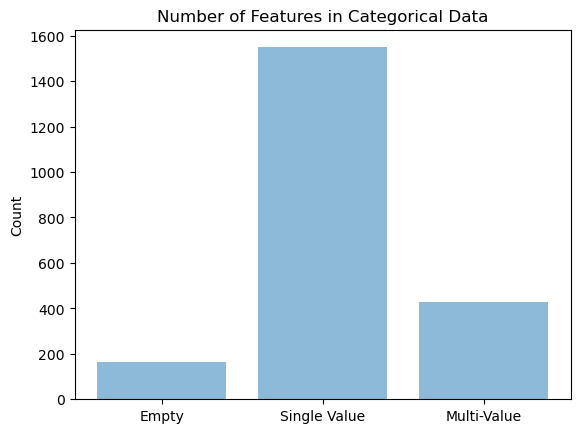

In [6]:
import matplotlib
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Empty', 'Single Value', 'Multi-Value')
y = np.arange(len(objects))
values = [empty,single,multi]
 
plt.bar(y, values, align='center', alpha=0.5)
plt.xticks(y, objects)
plt.ylabel('Count')
plt.title('Number of Features in Categorical Data')
 
plt.show()

In [61]:
# Categorical to one hot vectors

import numpy as np
import pandas as pd
from itertools import chain
import scipy.sparse as spar


def sparse_dummies(categories):
    num_rows = categories.shape[0]
    num_cats = len(categories.values.categories)
    if num_cats == 0: return None
    categories = categories.reset_index(drop=True)[categories.values.codes > -1]
    data = np.ones(categories.shape[0])
    return spar.csc_matrix(
        (data, (categories.index.values, categories.values.codes)),
        shape=(num_rows, num_cats))


def one_hot(df):
    df = df.apply(lambda col: col.astype('category'), axis=0)
    cat_counts = df.apply(lambda col: len(col.values.categories), axis=0)
    header = list(chain.from_iterable(
    [[colname] * ncats for colname, ncats in zip(cat_counts.index, cat_counts.values)]))

    dummy_matrices = (sparse_dummies(df[col]) for col in df.columns)
    # drop None's
    dummy_matrices = list(elem for elem in dummy_matrices if elem is not None)
    
    if len(dummy_matrices) == 0: return None, None
    mtx = spar.hstack(dummy_matrices)
    
    return header, mtx


def save_ohe(filename, header, matrix):
    np.savez(filename,
        header=header,
        indices=matrix.indices,
        indptr=matrix.indptr,
        shape=matrix.shape)


def load_ohe(filename):
    loader = np.load(filename)
    header = loader['header']
    indices = loader['indices']
    indptr = loader['indptr']
    data = np.ones(len(indices))
    mtx = spar.csc_matrix((data, indices, indptr), shape = loader['shape'])
    return header, mtx


def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

cat_path = r'C:\Users\draga\Documents\Time Series Forecasting - Anomaly Detection\bosch-production-line-performance\train_categorical.csv'
chunksize = 30 # number of columns to read at once

columns = pd.read_csv(
    cat_path,
    index_col=0,
    nrows = 1,
    dtype=str).columns.values

ncols = len(columns)
print(ncols)

headers = []
matrices = []
progress = 0

# read file in vertical chunks
for col_subset in chunker(columns, chunksize):
    progress += chunksize
    
    usecols = np.append(['Id'], col_subset)
    df = pd.read_csv(
        cat_path,
        index_col=0,
        dtype=str,
        usecols=usecols
    )
    df = df.T.drop_duplicates().T
    print(df.columns)
    df = df.dropna(axis=1, how='all')

    header, mtx = one_hot(df)
    if mtx is not None:
        matrices.append(mtx)
        headers.append(header)
        print("progress = {:.1f}% : {}".format(100.*progress / (1.*ncols), mtx.shape))


full_header = np.hstack(headers)
full_mtx = spar.hstack(matrices).tocsc()

print(full_header.shape)
print(full_mtx.shape)

with open('categorical_one_hot.npz', 'wb') as resfile:
    save_ohe(resfile, full_header, full_mtx)

header, mtx = load_ohe('categorical_one_hot.npz')

2140
Index(['L0_S1_F25', 'L0_S1_F27', 'L0_S1_F29', 'L0_S1_F31', 'L0_S2_F33',
       'L0_S2_F35', 'L0_S3_F69'],
      dtype='object')
progress = 1.4% : (1183747, 13)
Index(['L0_S3_F85', 'L0_S4_F105', 'L0_S4_F107', 'L0_S4_F108', 'L0_S4_F110',
       'L0_S4_F112', 'L0_S4_F113', 'L0_S6_F119', 'L0_S6_F121', 'L0_S9_F151',
       'L0_S9_F153', 'L0_S9_F154', 'L0_S9_F156'],
      dtype='object')
progress = 2.8% : (1183747, 31)
Index(['L0_S9_F158', 'L0_S9_F159', 'L0_S9_F161', 'L0_S9_F163', 'L0_S9_F164',
       'L0_S9_F166', 'L0_S9_F169', 'L0_S9_F176'],
      dtype='object')
progress = 4.2% : (1183747, 54)
Index(['L0_S9_F208', 'L0_S9_F209', 'L0_S9_F211', 'L0_S10_F215', 'L0_S10_F217',
       'L0_S10_F218', 'L0_S10_F220', 'L0_S10_F222', 'L0_S10_F223',
       'L0_S10_F230', 'L0_S10_F233'],
      dtype='object')
progress = 5.6% : (1183747, 79)
Index(['L0_S10_F257', 'L0_S10_F258', 'L0_S10_F260', 'L0_S11_F279',
       'L0_S11_F281'],
      dtype='object')
progress = 7.0% : (1183747, 21)
Index(['L0_S11_

progress = 72.9% : (1183747, 4)
Index(['L2_S26_F3057', 'L2_S26_F3058', 'L2_S26_F3082', 'L2_S26_F3099'], dtype='object')
progress = 74.3% : (1183747, 5)
Index(['L2_S26_F3105', 'L2_S26_F3108', 'L2_S27_F3131', 'L2_S27_F3132'], dtype='object')
progress = 75.7% : (1183747, 4)
Index(['L2_S27_F3161', 'L2_S27_F3164', 'L2_S27_F3192'], dtype='object')
progress = 77.1% : (1183747, 4)
Index(['L2_S27_F3212', 'L2_S27_F3213', 'L2_S28_F3224', 'L2_S28_F3225'], dtype='object')
progress = 78.5% : (1183747, 4)
Index(['L2_S28_F3268', 'L2_S28_F3269', 'L2_S28_F3285', 'L3_S29_F3317'], dtype='object')
progress = 79.9% : (1183747, 5)
Index(['L3_S29_F3320'], dtype='object')
progress = 81.3% : (1183747, 1)
Index(['L3_S29_F3406', 'L3_S29_F3475'], dtype='object')
progress = 82.7% : (1183747, 2)
Index(['L3_S29_F3490', 'L3_S30_F3495', 'L3_S30_F3497', 'L3_S30_F3498',
       'L3_S30_F3505', 'L3_S30_F3508'],
      dtype='object')
progress = 84.1% : (1183747, 8)
Index(['L3_S30_F3542', 'L3_S30_F3543', 'L3_S30_F3545', 'L3_

In [71]:
mtx[0, :].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [58]:
columns = pd.read_csv(
    cat_path,
    nrows = 1).columns.values

In [60]:
len(columns)

2141

In [4]:
import numpy as np
import numpy as np
import pandas as pd
from itertools import chain
import scipy.sparse as spar
def load_ohe(filename):
    loader = np.load(filename)
    header = loader['header']
    indices = loader['indices']
    indptr = loader['indptr']
    data = np.ones(len(indices))
    mtx = spar.csc_matrix((data, indices, indptr), shape = loader['shape'])
    return header, mtx
train_categorical = np.load("categorical_one_hot_2.npz")
header, mtx = load_ohe("categorical_one_hot_2.npz")

In [9]:
mtx.shape

(1183747, 988)

In [11]:
# Decomposition of sparse matrix : from 2141 features to 5 features
import numpy as np 
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA
X = mtx.toarray()
transformer = SparsePCA(n_components=5, random_state=0)
transformer.fit(X)
X_transformed = transformer.transform(X)
X_transformed.shape

(1183747, 5)

In [24]:
transformer.get_params()

{'U_init': None,
 'V_init': None,
 'alpha': 1,
 'max_iter': 1000,
 'method': 'lars',
 'n_components': 5,
 'n_jobs': None,
 'random_state': 0,
 'ridge_alpha': 0.01,
 'tol': 1e-08,
 'verbose': False}

In [15]:
train_categorical = pd.DataFrame(data=X_transformed)

In [17]:
train_categorical.to_pickle("train_categorical_processed.pkl")

In [10]:
# train_categorical.files # ['header', 'indices', 'indptr', 'shape']
train_categorical['shape'] # array([1183747,    4258])
# 67 650 937

array([1183747,    4258])

In [16]:
len(train_categorical['header'])

4258

In [26]:
header, mtx = load_ohe("categorical_one_hot.npz")

In [46]:
data_one_hot_sparse = pd.get_dummies(mtx, sparse=True)

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [31]:
print(mtx)

  (7800, 0)	1.0
  (12063, 0)	1.0
  (41533, 0)	1.0
  (41534, 0)	1.0
  (51457, 0)	1.0
  (91731, 0)	1.0
  (96543, 0)	1.0
  (159886, 0)	1.0
  (278255, 0)	1.0
  (304205, 0)	1.0
  (312757, 0)	1.0
  (322556, 0)	1.0
  (433244, 0)	1.0
  (433245, 0)	1.0
  (496029, 0)	1.0
  (512951, 0)	1.0
  (658499, 0)	1.0
  (697043, 0)	1.0
  (715835, 0)	1.0
  (718943, 0)	1.0
  (757191, 0)	1.0
  (759734, 0)	1.0
  (791873, 0)	1.0
  (875382, 0)	1.0
  (1005705, 0)	1.0
  :	:
  (730289, 4255)	1.0
  (803561, 4255)	1.0
  (803562, 4255)	1.0
  (808886, 4255)	1.0
  (895727, 4255)	1.0
  (941596, 4255)	1.0
  (970201, 4255)	1.0
  (997213, 4255)	1.0
  (1007949, 4255)	1.0
  (1011914, 4255)	1.0
  (1037460, 4255)	1.0
  (1095317, 4255)	1.0
  (1114579, 4255)	1.0
  (1155775, 4255)	1.0
  (1171215, 4255)	1.0
  (245588, 4256)	1.0
  (287587, 4256)	1.0
  (292893, 4256)	1.0
  (487439, 4256)	1.0
  (675637, 4256)	1.0
  (678361, 4256)	1.0
  (709397, 4256)	1.0
  (99498, 4257)	1.0
  (101319, 4257)	1.0
  (108076, 4257)	1.0


In [27]:
mtx

<1183747x4258 sparse matrix of type '<class 'numpy.float64'>'
	with 67650937 stored elements in Compressed Sparse Column format>

<b>DATE DATA</b>

In [33]:
# Explore dates
dates = []
for column in train_date.columns:
    if column == 'Id': continue
    dates.append(train_date[column].unique())
unique_dates = []
for array in dates:
    for date in list(array):
        unique_dates.append(date)
len(set(unique_dates))
sorted(set(unique_dates))

In [39]:
max(unique_dates)
# The maximum time is 1718.48
# 1 = 10 hours => 17184.8 hours = 716.03 days = 1.96 years or appriximately 2 years of data

1718.48

In [5]:
# Converting times to human readable timestamps
# Date dataset = 1 183 747 parts and 1157 features
# Each cell is the time when a part passed a feature

# Total number of cells = 1 183 747 x 1157 = 1 369 595 279
# Of which 
# train_date.isna().sum().sum() # 1 125 431 152 are null
# 82.17% cells are null

df = train_date.drop(columns=['Id'])
# Find unique times and how many times they occured in the dataset
date_cnt = {}
for column in df.columns:
    for items in df[column].value_counts().iteritems():
        try:
            cnt = date_cnt[items[0]]
            cnt = cnt + items[1]
            date_cnt[items[0]] = cnt
        except: date_cnt[items[0]] = items[1]
date_cnt = dict(sorted(date_cnt.items()))

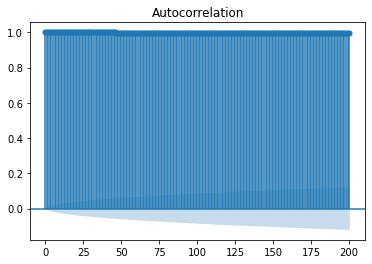

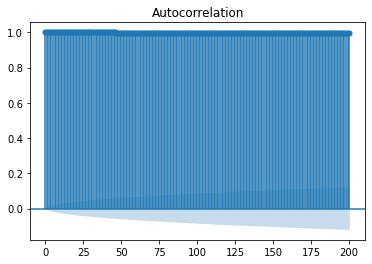

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(list(date_cnt.keys()), lags=200)
#data: your time series
#lags: number of 'periods' you will like to investigate 

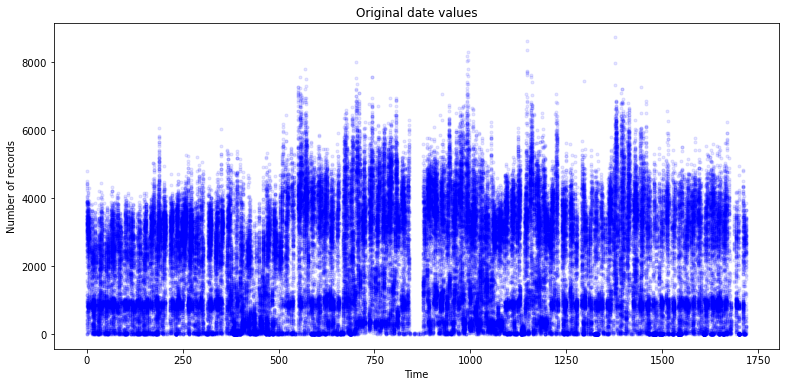

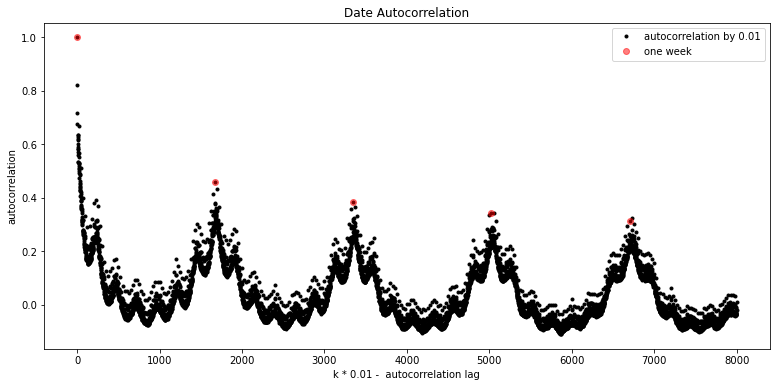

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Plot unique times and how many times they occured in the dataset
fig = plt.figure(figsize=(13,6))
# alpha is for line transparancy
plt.plot(date_cnt.keys(), date_cnt.values(), 'b.', alpha=0.1)
plt.title('Original date values')
plt.ylabel('Number of records')
plt.xlabel('Time')
plt.show()

# Figuring out what is 0.01
time_ticks = np.arange(min(date_cnt.keys()), max(date_cnt.keys()) + 0.01, 0.01)
train_time_cnt = pd.DataFrame({'cnt': date_cnt.values()})
train_time_cnt['time'] = date_cnt.keys()
time_ticks = pd.DataFrame({'time': time_ticks})
time_ticks = pd.merge(time_ticks, train_time_cnt, how='left', on='time')
time_ticks = time_ticks.fillna(0)
# Autocorrelation
x = time_ticks['cnt'].values
max_lag = 8000
auto_corr_ks = range(1, max_lag)
auto_corr = np.array([1] + [np.corrcoef(x[:-k], x[k:])[0, 1] for k in auto_corr_ks])
fig = plt.figure(figsize=(13,6))
plt.plot(auto_corr, 'k.', label='autocorrelation by 0.01')
plt.title('Date Autocorrelation')
period = 1675
auto_corr_ks = list(range(period, max_lag, period))
auto_corr = np.array([1] + [np.corrcoef(x[:-k], x[k:])[0, 1] for k in auto_corr_ks])
plt.plot([0] + auto_corr_ks, auto_corr, 'ro', markersize=6, alpha=0.5, label='one week')
plt.xlabel('k * 0.01 -  autocorrelation lag')
plt.ylabel('autocorrelation')
plt.legend(loc=0)

In [8]:
# Time features
# min time part, max time part, duration part, time lapse (TMAX-TMIN)= time difference,
# max time station, min time station and part week
import numpy as np

train_date_features = pd.DataFrame()
Id = list(train_date.loc[:,"Id"])
train_date_features['Id'] = Id

features = train_date.drop(columns=["Id"])

max = features.max(axis=1)
train_date_features['max'] = max
min = features.min(axis=1)
train_date_features['min'] = min
train_date_features['time_difference'] = train_date_features['max'] - train_date_features['min']

# Find the part of the week
week_duration = 1679
train_date_features['part_week'] = ((train_date_features['min'].values*100) % week_duration).astype(np.int64)

# Find the station with the minimum time (the starting station)
# idxmin() method returns a Series with the index of the minimum value for each column
train_date_features['min_time_station'] = features.idxmin(axis=1).apply(lambda column: int(column.split('_')[1][1:]) if column is not np.nan else -1)
# Find the station with the maximum time (the ending station)
train_date_features['max_time_station'] = features.idxmax(axis=1).apply(lambda column: int(column.split('_')[1][1:]) if column is not np.nan else -1)

In [16]:
# path length
# how many stations were now null
# substract by 1 because of the Id column
train_date_features['path_length'] = train_date.apply(lambda x: x.count()-1, axis=1)

In [29]:
# End part of week (mod 1679)
train_date_features['part_week_end'] = ((train_date_features['max'].values*100) % week_duration).astype(np.int64)

In [31]:
# Making the intervals per day
# 1508	334 STARTED ON SUNDAY, ENDED ON TUESDAY

# 0-239 MONDAY
# 239-479 TUESDAY 
# 480-719 WEDNESDAY
# 720-959 THURSDAY
# 960-1199 FRIDAY
# 1200-1439 SATURDAY
# 1440-1679 SUNDAY

In [7]:
train_date_features.to_pickle("train_date_features.pkl")

In [1]:
import pandas as pd
train_numerical = pd.read_pickle("train_numeric.pkl")
train_date = pd.read_pickle("train_date.pkl")
train_date_features = pd.read_pickle("train_date_features.pkl")

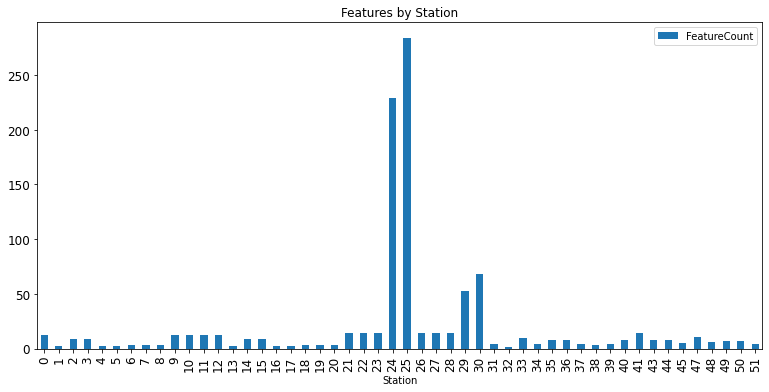

In [4]:
 def get_features(feature_list):
    line_features = {}
    station_features = {}
    lines = set([item.split('_')[0] for item in feature_list])
    stations = set([item.split('_')[1] for item in feature_list])

    for l in lines:
        line_features[l] = [item for item in feature_list if '%s_' % l in item]

    for s in stations:
        station_features[s] = [item for item in feature_list if '%s_' % s in item]

    return (line_features, station_features)

def explore_features(dataset):
    # how many units processed in each station
    features = dataset.drop(["Response", "Id"], axis=1).columns.values
    line_features, station_features = get_features(features)
    # station, features_count
    sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])
    sdf = sdf.sort_values(by=['Station'])
    stations_plot = sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Features by Station",
                             figsize=(13,6), fontsize=12)

explore_features(train_numerical)

In [42]:
# Add feature: day of week when the part started
def day_of_week(column):
    result = []
    for row in train_date_features[column]:
        if row >= 0 and row <= 239:
            result.append(1)
        elif row >= 240 and row <= 479:
            result.append(2)
        elif row >= 480 and row <= 719:
            result.append(3)
        elif row >= 720 and row <= 959:
            result.append(4) 
        elif row >= 960 and row <= 1199:
            result.append(5)
        elif row >= 1200 and row <= 1439:
            result.append(6)
        elif row >= 1440 and row <= 1679:
            result.append(7)
        else: result.append(None)
    return result
        
day_of_week_start = day_of_week('part_week_start')
day_of_week_end = day_of_week('part_week_end')
# 0-239 MONDAY 1
# 240-479 TUESDAY 2
# 480-719 WEDNESDAY 3
# 720-959 THURSDAY 4
# 960-1199 FRIDAY 5
# 1200-1439 SATURDAY 6
# 1440-1679 SUNDAY 7

In [4]:
train_date_features['day_of_week_start'] = day_of_week_start
train_date_features['day_of_week_end'] = day_of_week_end

In [5]:
# Normalize part of week
train_date_features['part_week_start'] = train_date_features['part_week_start'] / 100
train_date_features['part_week_end'] = train_date_features['part_week_end'] / 100

In [32]:
result, stations = [], []
for column in train_date.columns:
    if list(train_date[train_date['Id']==166910][column])[0]>0:
        result.append(list(train_date[train_date['Id']==166910][column])[0])
        if column not in stations: stations.append(column)

In [25]:
list(train_date[train_date['Id']==166910][column])[0]

166910

In [9]:
train_date_features[train_date_features['Id']==166910]

,Id,max,min,time_difference,min_time_station,max_time_station,path_length,part_week_start,part_week_end,day_of_week_start,day_of_week_end
83210,166910,256.23,255.31,0.92,0,36,175,3.46,4.38,2.0,2.0


In [2]:
train_date_features[train_date_features['Id']==166941]

,Id,max,min,time_difference,min_time_station,max_time_station,path_length,part_week_start,part_week_end,day_of_week_start,day_of_week_end
83231,166941,719.61,669.5,50.11,25,50,153,1469,1443,7.0,7.0


In [41]:
df = train_date[train_date['Id']==166941].head(1)

for column in df.columns:
    print(df[column])

83231    166941
Name: Id, dtype: int64
83231   NaN
Name: L0_S0_D1, dtype: float64
83231   NaN
Name: L0_S0_D3, dtype: float64
83231   NaN
Name: L0_S0_D5, dtype: float64
83231   NaN
Name: L0_S0_D7, dtype: float64
83231   NaN
Name: L0_S0_D9, dtype: float64
83231   NaN
Name: L0_S0_D11, dtype: float64
83231   NaN
Name: L0_S0_D13, dtype: float64
83231   NaN
Name: L0_S0_D15, dtype: float64
83231   NaN
Name: L0_S0_D17, dtype: float64
83231   NaN
Name: L0_S0_D19, dtype: float64
83231   NaN
Name: L0_S0_D21, dtype: float64
83231   NaN
Name: L0_S0_D23, dtype: float64
83231   NaN
Name: L0_S1_D26, dtype: float64
83231   NaN
Name: L0_S1_D30, dtype: float64
83231   NaN
Name: L0_S2_D34, dtype: float64
83231   NaN
Name: L0_S2_D38, dtype: float64
83231   NaN
Name: L0_S2_D42, dtype: float64
83231   NaN
Name: L0_S2_D46, dtype: float64
83231   NaN
Name: L0_S2_D50, dtype: float64
83231   NaN
Name: L0_S2_D54, dtype: float64
83231   NaN
Name: L0_S2_D58, dtype: float64
83231   NaN
Name: L0_S2_D62, dtype: float6

83231   NaN
Name: L1_S25_D2387, dtype: float64
83231   NaN
Name: L1_S25_D2392, dtype: float64
83231   NaN
Name: L1_S25_D2397, dtype: float64
83231   NaN
Name: L1_S25_D2402, dtype: float64
83231   NaN
Name: L1_S25_D2406, dtype: float64
83231   NaN
Name: L1_S25_D2409, dtype: float64
83231   NaN
Name: L1_S25_D2412, dtype: float64
83231   NaN
Name: L1_S25_D2415, dtype: float64
83231   NaN
Name: L1_S25_D2418, dtype: float64
83231   NaN
Name: L1_S25_D2421, dtype: float64
83231   NaN
Name: L1_S25_D2424, dtype: float64
83231   NaN
Name: L1_S25_D2427, dtype: float64
83231   NaN
Name: L1_S25_D2430, dtype: float64
83231   NaN
Name: L1_S25_D2432, dtype: float64
83231   NaN
Name: L1_S25_D2434, dtype: float64
83231   NaN
Name: L1_S25_D2436, dtype: float64
83231   NaN
Name: L1_S25_D2438, dtype: float64
83231   NaN
Name: L1_S25_D2440, dtype: float64
83231   NaN
Name: L1_S25_D2442, dtype: float64
83231   NaN
Name: L1_S25_D2444, dtype: float64
83231   NaN
Name: L1_S25_D2445, dtype: float64
83231   NaN
N

Name: L3_S51_D4263, dtype: float64


<b>INVESTIGATE FAULTS</b>

In [7]:
# Failure
# 1 = failure
# Total parts = 1 183 747
len(train_numerical[train_numerical['Response'] == 1]) # 6879 are failed

# 0.006 error

6879

In [7]:
# 6879 failed parts out of 1183747 = 0.58% failure rate
train_numerical[train_numerical['Response']==1]

In [2]:
# Investigate faults
import operator
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

def plot_bar_chart(data, title):
    plt.figure(figsize=(10,10))
    sorted_data = OrderedDict(sorted(data.items(), key=operator.itemgetter(1)))
    index = np.arange(len(sorted_data))
    plt.barh(index, sorted_data.values())
    plt.yticks(index, sorted_data.keys(), size=12)
    plt.title(title)
    plt.show()

get_cols = lambda keyword: [c for c in train_numerical if '{}_'.format(keyword) in c]

lines = set(c.split('_')[0] for c in train_numerical[0:5] if '_' in c)
stations = set(c.split('_')[1] for c in train_numerical[0:5] if '_' in c)
features = set(c.split('_')[2] for c in train_numerical[0:5] if '_' in c)

line_faults, station_faults = {}, {}

for line in lines:
    line_cols = get_cols(line)
    in_line_ix = train_numerical[line_cols].isnull().mean(axis=1) != 1.0
    line_faults[line] = np.mean(train_numerical[in_line_ix]['Response'])
    
for station in stations:
    station_cols = get_cols(station)
    in_station_ix = train_numerical[station_cols].isnull().mean(axis=1) != 1.0
    station_faults[station] = np.mean(train_numerical[in_station_ix]['Response'])
    
plot_bar_chart(line_faults, title='Fault by Line')
plot_bar_chart(station_faults, title='Fault by Station')

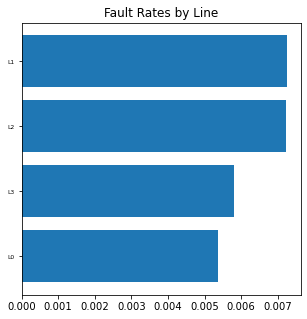

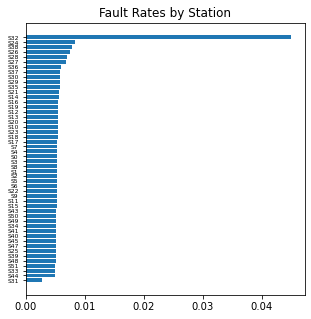

In [63]:
# Result from previous code

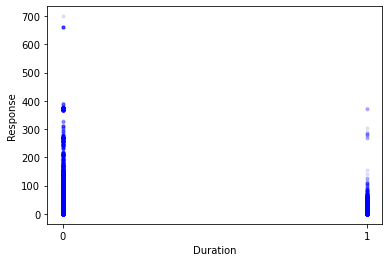

In [5]:
# The error rate is proportional to the time difference(max time-min time)
# 'Response' = 1 = fails
import matplotlib.pyplot as plt

# Plot the response and the duration per part
x = train_numerical["Response"]
y = train_date_features['time_difference']
fig = plt.figure()
plt.plot(x, y, 'b.', alpha=0.1)
x_ticks = [0, 1]
x_labels = [0, 1]
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.ylabel('Response')
plt.xlabel('Duration')
plt.show()

In [5]:
# Z-stats If a z-score is 0, it indicates that the data point's score is identical to the mean score. A z-score of 1.0 would indicate a value that is one standard deviation from the mean. Z-scores may be positive or negative, with a positive value indicating the score is above the mean and a negative score indicating it is below the mean.
# Let's take into account the null values

# Positive = prone to failures
# Negative = not prone to failures

# Mean for the response values
mean = train_numerical["Response"].mean()

fault_zstats = {}
for station in stations:
    station_cols = get_cols(station)
    in_station_ix = train_numerical[station_cols].isnull().mean(axis=1) != 1.0
    fault_mean = np.mean(train_numerical[in_station_ix]['Response'])
    fault_std_error = np.sqrt(fault_mean*(1.0-fault_mean) / np.sum(in_station_ix))
    if fault_std_error > 0:
        fault_zstats[station] = (fault_mean - 0.mean) / fault_std_error

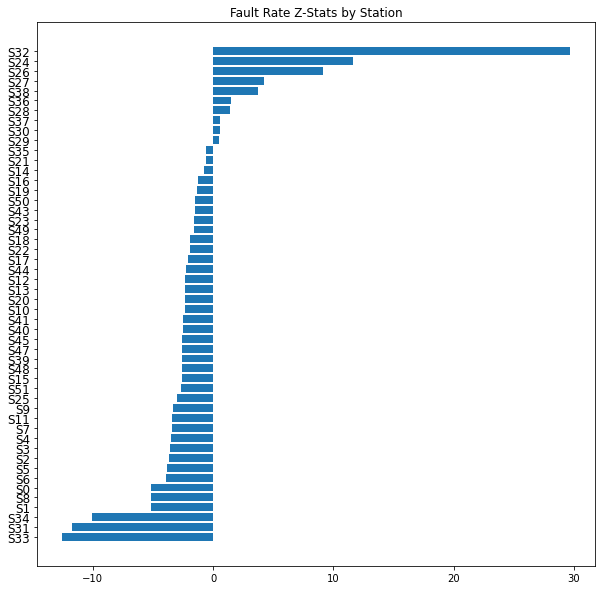

In [23]:
plot_bar_chart(fault_zstats, title='Fault Rate Z-Stats by Station')

In [22]:
# Try numerical or categorical againts time

In [13]:
# Next, we will investigate which features are particularly correlated with quality control failures. 
# For that we we'll use Spearman and Pearson

# The Pearson correlation coefficient [1] measures the linear relationship between two datasets.
# Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. 
# Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y.
# Negative correlations imply that as x increases, y decreases. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

# The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. 
# Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. 
# Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y.
# Negative correlations imply that as x increases, y decreases. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets.
from collections import OrderedDict
from scipy.stats import pearsonr, spearmanr

pearson, spearman = OrderedDict(), OrderedDict()
for feature in train_numerical:
    if feature in ['Id', 'Response']:
        continue
    # the sign ~ inverts all the bits
    ix = ~train_numerical[feature].isnull()
    # returns statistics(Pearson product-moment correlation coefficient.), pvalue (The p-value associated with the chosen alternative. )
    # correlation between the failed parts and the feature values for that response (null-not null dataset)
    pearson[feature] = pearsonr(train_numerical['Response'][ix], train_numerical[feature][ix])
    # returns Spearman correlation matrix or correlation coefficient (if only 2 variables are given as parameters). Correlation matrix is square with length equal to total number of variables (columns or rows) in a and b combined 
    # The p-value for a hypothesis test whose null hypothesis is that two sets of data are linearly uncorrelated.
    spearman[feature] = spearmanr(train_numerical['Response'][ix], train_numerical[feature][ix])

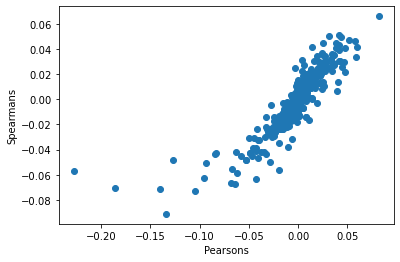

In [37]:
import matplotlib.pyplot as plt
pearsons_corr = [v[0] for v in pearson.values()]
spearmans_corr = [v[0] for v in spearman.values()]
plt.scatter(pearsons_corr, spearmans_corr)
plt.xlabel('Pearsons')
plt.ylabel('Spearmans')
plt.show()

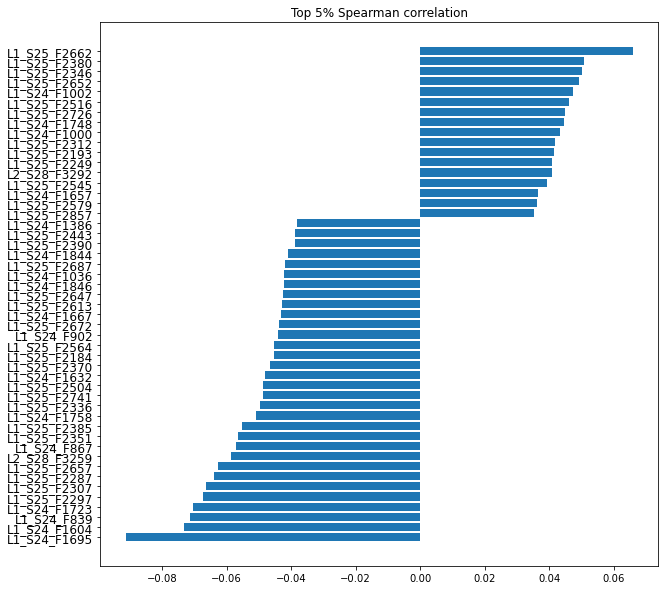

In [44]:
# Let's select the top 5% most correlated features
import numpy as np
import pandas as pd
import operator
abs_corrs = np.abs([v[0] for v in spearman.values() if not np.isnan(v[0])])
corr_threshold = np.percentile(abs_corrs, [95])
top5 = {k: v[0] for k, v in spearman.items() if np.abs(v[0]) > corr_threshold}
plot_bar_chart(top5, 'Top 5% {} correlation'.format('Spearman'))

# Conclusion
# These are mostly features from line 1 and stations 24 or 25. 

<b>REDUCING NULLS IN NUMERICAL DATA</b>

In [3]:
import pandas as pd
train_numerical = pd.read_pickle("train_numeric.pkl")
train_date = pd.read_pickle("train_date.pkl")
train_date_features = pd.read_pickle("train_date_features.pkl")

In [7]:
# total rows 1183747
# 99% from 1183747 = 1.171.909
# 95% = 1124559

In [4]:
# Check missing values in numerical
# Total number of cells = 1 183 747 x 970 = 1 148 234 590
# Of which 
# print(train_numerical.isna().sum().sum()) # 929 125 166 are null
# 80.91% cells are null

nulls = []
for column in train_numerical.columns:
    if train_numerical[column].isna().sum() >= 1171910:
        nulls.append(column)

In [67]:
print(train_numerical_processed.isna().sum().sum())

546346958


In [5]:
str(nulls) # 227

"['L1_S24_F907', 'L1_S24_F920', 'L1_S24_F925', 'L1_S24_F930', 'L1_S24_F935', 'L1_S24_F948', 'L1_S24_F953', 'L1_S24_F958', 'L1_S24_F963', 'L1_S24_F968', 'L1_S24_F973', 'L1_S24_F978', 'L1_S24_F983', 'L1_S24_F988', 'L1_S24_F993', 'L1_S25_F2181', 'L1_S25_F2184', 'L1_S25_F2187', 'L1_S25_F2190', 'L1_S25_F2193', 'L1_S25_F2196', 'L1_S25_F2199', 'L1_S25_F2202', 'L1_S25_F2207', 'L1_S25_F2210', 'L1_S25_F2217', 'L1_S25_F2220', 'L1_S25_F2223', 'L1_S25_F2226', 'L1_S25_F2231', 'L1_S25_F2233', 'L1_S25_F2237', 'L1_S25_F2239', 'L1_S25_F2241', 'L1_S25_F2243', 'L1_S25_F2245', 'L1_S25_F2247', 'L1_S25_F2249', 'L1_S25_F2258', 'L1_S25_F2263', 'L1_S25_F2268', 'L1_S25_F2273', 'L1_S25_F2278', 'L1_S25_F2287', 'L1_S25_F2292', 'L1_S25_F2297', 'L1_S25_F2302', 'L1_S25_F2307', 'L1_S25_F2312', 'L1_S25_F2317', 'L1_S25_F2322', 'L1_S25_F2327', 'L1_S25_F2336', 'L1_S25_F2341', 'L1_S25_F2346', 'L1_S25_F2351', 'L1_S25_F2356', 'L1_S25_F2365', 'L1_S25_F2370', 'L1_S25_F2375', 'L1_S25_F2380', 'L1_S25_F2385', 'L1_S25_F2390', 'L1_S

In [7]:
null_not_fault = []
for column in nulls:
    if len(train_numerical[[column, 'Response']].loc[(train_numerical[column] > 0) & (train_numerical['Response']==1)]) == 0:
        null_not_fault.append(column)

In [8]:
null_not_fault

['L1_S25_F2181',
 'L1_S25_F2263',
 'L1_S25_F2508',
 'L1_S25_F2510',
 'L1_S25_F2512',
 'L1_S25_F2525',
 'L1_S25_F2564',
 'L1_S25_F2712',
 'L1_S25_F2724',
 'L2_S28_F3241',
 'L2_S28_F3263']

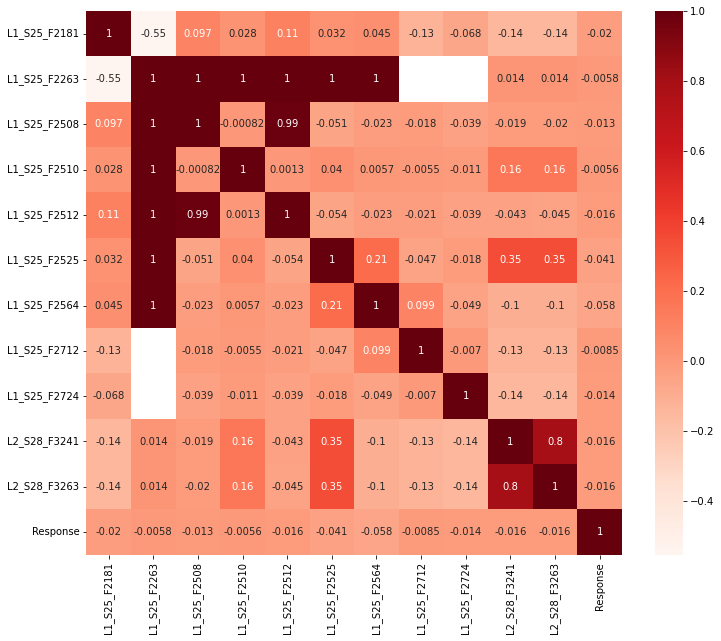

In [68]:
# Using Pearson Correlation for null_not_fault and Response
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
cor = train_numerical[['L1_S25_F2181','L1_S25_F2263','L1_S25_F2508','L1_S25_F2510','L1_S25_F2512','L1_S25_F2525','L1_S25_F2564','L1_S25_F2712','L1_S25_F2724','L2_S28_F3241','L2_S28_F3263', 'Response']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [9]:
# drop 11 columns
train_numerical_processed = train_numerical.drop(['L1_S25_F2181','L1_S25_F2263','L1_S25_F2508','L1_S25_F2510','L1_S25_F2512','L1_S25_F2525','L1_S25_F2564','L1_S25_F2712','L1_S25_F2724','L2_S28_F3241','L2_S28_F3263'], axis=1)

In [11]:
# Feature Importance and Feature Selection With XGBoost in Python
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from matplotlib import pyplot

# define dataset
# total: 216 features
X = train_numerical_processed[train_numerical_processed.columns[train_numerical_processed.columns.isin(nulls)]]
y = train_numerical_processed['Response']
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_

In [13]:
# summarize feature importance
import numpy as np
indices = np.argsort(importance)
features = np.array(X.columns)[indices]
columns = []
result = []
for i, v in enumerate(importance):
    if v <= 0.005:
        result.append('Feature: %s, Score: %.5f' % (features[i],v))
        columns.append(features[i])

In [66]:
train_numerical_processed.to_pickle("train_numerical_processed.pkl")

In [15]:
train_numerical_processed=train_numerical_processed.drop(columns, axis=1)

In [56]:
# Feature Importance and Feature Selection With XGBoost in Python
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from matplotlib import pyplot

# define dataset
# total: 852 features
X = train_numerical_processed.iloc[: ,  426:852]
y = train_numerical_processed['Response']
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_

In [57]:
# summarize feature importance on not 99% null columns
import numpy as np
indices = np.argsort(importance)
features = np.array(X.columns)[indices]
columns = []
result = []
for i, v in enumerate(importance):
    if v == 0:
        result.append('Feature: %s, Score: %.5f' % (features[i],v))
        columns.append(features[i])

In [60]:
null_second_part = []
for column in columns:
    if train_numerical_processed[column].isna().sum() >= 1124559:
        null_second_part.append(column)

In [64]:
train_numerical_processed=train_numerical_processed.drop(null_first_part, axis=1)
train_numerical_processed=train_numerical_processed.drop(null_second_part, axis=1)
# 546 346 958 = 47.58% cells are null

In [ ]:
# Null to 0